<h1><span style="color:DodgerBlue;font-family:'Arial';">Serieclustring for HeCore</span></h1><br>

Versjon: juni 2018

<div style="font-family:'Palatino Linotype';font-size:1.2em;">

<h2><span style="color:gray;font-family:'Arial';">Om notebooken</span></h2><br>

Første celle nedenfor er en javascript-celle som ved aktivering sørger for å skjule mesteparten av koden. For å se på koden er det bare å bytte ut tallet for 'height' med 'auto'.</div>

In [1]:
%%javascript
// Skjul koden i påfølgende celle
// kode for å finne gjeldene celle er hentet fra bruker minrk på SO
var cell_element = this.element.parents('.cell');
var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);

$('.CodeMirror').eq(cell_idx+1).css('height', '70')
$('.CodeMirror').eq(cell_idx+2).css('height', '400')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json
import requests
from IPython.display import HTML
import seaborn as sns
from scipy.spatial.distance import cosine
import networkx as nx

sns.set_style('white')
%matplotlib inline

In [3]:
def get_freq(urn, top=50, cutoff=3):
    r = requests.get("https://api.nb.no/ngram/urnfreq", json={'urn':urn, 'top':top, 'cutoff':cutoff})
    return Counter(dict(r.json()))

def get_urn(metadata):
    r = requests.get('https://api.nb.no/ngram/urn', json=metadata)
    return r.json()

def get_papers(top=5, cutoff=5, navn='%', yearfrom=1800, yearto=2020, samplesize=100):
    
    div = lambda x, y: (int(x/y), x % y)
    chunks = 20
    
    
    # split samplesize into chunks, go through the chunks and then the remainder
    
    (first, second) = div(samplesize, chunks)
    r = []
    
    # collect chunkwise 
    for i in range(first):
        r += requests.get("https://api.nb.no/ngram/avisfreq", json={'navn':navn, 'top':top, 'cutoff':cutoff,
                                                              'yearfrom':yearfrom, 'yearto':yearto,'samplesize':chunks}
                         ).json()
    
    
    # collect the remainder
    r += requests.get("https://api.nb.no/ngram/avisfreq", json={'navn':navn, 'top':top, 'cutoff':cutoff,
                                                              'yearfrom':yearfrom, 'yearto':yearto,'samplesize':second}
                         ).json()

    return [dict(x) for x in r]

def collocation(word, yearfrom=2010, yearto=2018, before=3, after=3, limit=1000, corpus='avis'):
    data =  requests.get(
        "https://api.nb.no/ngram/collocation", 
        params={
            'word':word,
            'corpus':corpus, 
            'yearfrom':yearfrom, 
            'before':before,
            'after':after,
            'limit':limit,
            'yearto':yearto}).json()
    return pd.DataFrame.from_dict(data['freq'], orient='index')

def heatmap(df, color='green'):
    return df.fillna(0).style.background_gradient(cmap=sns.light_palette(color, as_cmap=True))

def get_corpus_text(urns, top = 10000, cutoff=5):
    k = dict()
    for u in urns:
        #print(u)
        k[u] = get_freq(u, top = top, cutoff = cutoff)
    return pd.DataFrame(k)

def normalize_corpus_dataframe(df):
    colsums = df.sum()
    for x in colsums.index:
        #print(x)
        df[x] = df[x].fillna(0)/colsums[x]
    return True

def show_korpus(korpus, start=0, size=4, vstart=0, vsize=20, sortby = ''):
    """Show corpus as a panda dataframe
    start = 0 indicates which dokument to show first, dataframe is sorted according to this
    size = 4 how many documents (or columns) are shown
    top = 20 how many words (or rows) are shown"""
    if sortby != '':
        val = sortby
    else:
        val = korpus.columns[start]
    return korpus[korpus.columns[start:start+size]].sort_values(by=val, ascending=False)[vstart:vstart + vsize]

def aggregate(korpus):
    """Make an aggregated sum of all documents across the corpus, here we use average"""
    return pd.DataFrame(korpus.fillna(0).mean(axis=1))

def convert_list_of_freqs_to_dataframe(referanse):
    """The function get_papers() returns a list of frequencies - convert it"""
    res = []
    for x in referanse:
        res.append( dict(x))
    result = pd.DataFrame(res).transpose()
    normalize_corpus_dataframe(result)
    return result

def get_corpus(top=5, cutoff=5, navn='%', corpus='avis', yearfrom=1800, yearto=2020, samplesize=10):
    if corpus == 'avis':
        result = get_papers(top=top, cutoff=cutoff, navn=navn, yearfrom=yearfrom, yearto=yearto, samplesize=samplesize)
        res = convert_list_of_freqs_to_dataframe(result)
    else:
        urns = get_urn({'author':navn, 'year':yearfrom, 'neste':yearto-yearfrom, 'limit':samplesize})
        res = get_corpus_text([x[0] for x in urns], top=top, cutoff=cutoff)
    return res


def make_a_collocation(word, period=(1990, 2000),before=5, after=5,corpus='avis', samplesize=100, limit=2000):
    collocates = collocation(word, yearfrom=period[0], yearto = period[1], before=before, after=after,
                            corpus=corpus, limit=limit)
    collocates.columns = [word]
    reference = get_corpus(yearfrom=period[0], yearto=period[1], samplesize=samplesize)
    ref_agg = aggregate(reference)
    ref_agg.columns = ['reference_corpus']
    return  ref_agg



def compute_assoc(coll_frame, column, exponent=1.1, refcolumn = 'reference_corpus'):
    return pd.DataFrame(coll_frame[column]**exponent/coll_frame.mean(axis=1))
    

class Cluster:
    from IPython.display import HTML, display
    import pandas as pd
    import json
    
    def __init__(self, word = '', filename = '', period = (1950,1960) , before = 5, after = 5, corpus='avis', reference = 200, 
                 word_samples=1000):
        import pandas
        
        if word != '':
            self.collocates = collocation(word, yearfrom=period[0], yearto = period[1], before=before, after=after,
                                corpus=corpus, limit=word_samples)
            self.collocates.columns = [word]
            if type(reference) is pandas.core.frame.DataFrame:
                reference = reference
            elif type(reference) is int:
                reference = get_corpus(yearfrom=period[0], yearto=period[1], corpus=corpus, samplesize=reference)
            else:
                reference = get_corpus(yearfrom=period[0], yearto=period[1], corpus=corpus, samplesize=int(reference))

            self.reference = aggregate(reference)
            self.reference.columns = ['reference_corpus']        
            self.word = word
            self.period = period
            self.corpus = corpus
        else:
            if filename != '':
                self.load(filename)
            
                
    def cluster_set(self, exponent=1.1, top = 200, aslist=True):
        combo_corp = self.reference.join(self.collocates, how='outer')
        normalize_corpus_dataframe(combo_corp)
        korpus = compute_assoc(combo_corp, self.word, exponent)
        korpus.columns = [self.word]
        res = korpus.sort_values(by=self.word, ascending=False).iloc[:top]
        if aslist == True:
            res = HTML(', '.join(list(res.index)))
        return res
    
    def add_reference(self, number=20):
        ref = get_corpus(yearfrom=self.period[0], yearto=self.period[1], samplesize=number)
        ref = aggregate(ref)
        ref.columns = ['add_ref']
        normalize_corpus_dataframe(ref)
        self.reference = aggregate(self.reference.join(ref, how='outer'))
        return True
    
    def save(self, filename=''):
        if filename == '':
            filename = "{w}_{p}-{q}.json".format(w=self.word,p=self.period[0], q = self.period[1])
        model = {
            'word':self.word,
            'period':self.period,
            'reference':self.reference.to_dict(),
            'collocates':self.collocates.to_dict(),
            'corpus':self.corpus
        }
        with open(filename, 'w', encoding = 'utf-8') as outfile:
            print('lagrer til:', filename)
            outfile.write(json.dumps(model))
        return True

    def load(self, filename):
        with open(filename, 'r') as infile:
            try:
                model = json.loads(infile.read())
                #print(model['word'])
                self.word = model['word']
                self.period = model['period']
                self.corpus = model['corpus']
                self.reference = pd.DataFrame(model['reference'])
                self.collocates = pd.DataFrame(model['collocates'])
            except:
                print('noe gikk galt')
        return True
    
    def search_words(self, words, exponent=1.1):
        if type(words) is str:
            words = [w.strip() for w in words.split()]
        sub = [w for w in words if w in self.cluster_set(exponent=exponent, top=0, aslist=False).index]
        return self.cluster_set(exponent=exponent, top=0, aslist=False).transpose()[sub].transpose().sort_values(by=self.word, ascending=False)
            
        

            
def make_newspaper_network(key, wordbag, titel='%', yearfrom='1980', yearto='1990', limit=500):
    import networkx as nx
    if type(wordbag) is str:
        wordbag = wordbag.split()
    r = requests.post("https://api.nb.no/ngram/avisgraph", json={
        'key':key, 
        'words':wordbag,
        'yearto':yearto,
    'yearfrom':yearfrom,
    'limit':limit})
    G = nx.Graph()
    if r.status_code == 200:
        G.add_weighted_edges_from([(x,y,z) for (x,y,z) in r.json() if z > 0 and x != y])
    else:
        print(r.text)
    return G

def make_network(urn, wordbag, cutoff=0):
    if type(urn) is list:
        urn = urn[0]
    if type(wordbag) is str:
        wordbag = wordbag.split()
    G = make_network_graph(urn, wordbag, cutoff)
    return G

def make_network_graph(urn, wordbag, cutoff=0):
    import networkx as nx
    
    r = requests.post("https://api.nb.no/ngram/graph", json={'urn':urn, 'words':wordbag})
    G = nx.Graph()
    G.add_weighted_edges_from([(x,y,z) for (x,y,z) in r.json() if z > cutoff and x != y])
    return G

def draw_graph_centrality(G, h=15, v=10, fontsize=20, k=0.2, arrows=False, font_color='black', threshold=0.01): 
    from pylab import rcParams
    import matplotlib.pyplot as plt
    
    node_dict = nx.degree_centrality(G)
    subnodes = dict({x:node_dict[x] for x in node_dict if node_dict[x] >= threshold})
    x, y = rcParams['figure.figsize']
    rcParams['figure.figsize'] = h, v
    pos =nx.spring_layout(G, k=k)
    ax = plt.subplot()
    ax.set_xticks([])
    ax.set_yticks([])
    G = G.subgraph(subnodes)
    nx.draw_networkx_labels(G, pos, font_size=fontsize, font_color=font_color)
    nx.draw_networkx_nodes(G, pos, alpha=0.5, nodelist=subnodes.keys(), node_size=[v * 1000 for v in subnodes.values()])
    nx.draw_networkx_edges(G, pos, alpha=0.7, arrows=arrows, edge_color='lightblue', width=1)

    rcParams['figure.figsize'] = x, y
    return True

def combine(clusters):
    """Make new collocation analyses from data in clusters"""
    colls = []
    collocates = clusters[0].collocates
    for c in clusters[1:]:
        collocates = collocates.join(c.collocates, rsuffix='-' + str(c.period[0]))
    return collocates

def cluster_join(cluster):
    clusters = [cluster[i] for i in cluster]
    clst = clusters[0].cluster_set(aslist=False)
    for c in clusters[1:]:
        clst = clst.join(c.cluster_set(aslist=False), rsuffix = '_'+str(c.period[0]))
    return clst

def serie_cluster(word, startår, sluttår, inkrement, before=5, after=5, reference=150, word_samples=500):
    tidscluster = dict()
    for i in range(startår, sluttår, inkrement):
        tidscluster[i] = Cluster(
        word, 
        corpus='avis', 
        period=(i, i + inkrement - 1), 
        before=after, 
        after=after, 
        reference=reference, 
        word_samples=word_samples)
        print(i, i+inkrement - 1)
    return tidscluster

def save_serie_cluster(tidscluster):
    for i in tidscluster:
        tidscluster[i].save()
    return 'OK'

def les_serie_cluster(word, startår, sluttår, inkrement):
    tcluster = dict()
    for i in range(startår, sluttår, inkrement):
        print(i, i+inkrement - 1)
        tcluster[i] = Cluster(filename='{w}_{f}-{t}.json'.format(w=word, f=i,t=i+inkrement - 1))
    return tcluster

<h2> <span style='color:tomato; font-family:"Arial"'>Lag kollokasjoner for tidsperioder og nettverk for ord</span></h2><br>

<div style="font-family:'Palatino Linotype';font-size:1.2em">

Definer en serie cluster over en tidsperiode. Clusteret bygges med kommandoen **serie_cluster()** som i tillegg til Cluster-kommandoen tar parametrene startår, sluttår og årsinkrementet. Sjekk opp eksemplet under. Kommandoen skriver ut periodene etterhvert som de blir klare.

</div>

In [119]:
tidscluster = serie_cluster(
    'demokrati', 
    1950, 
    2000, 
    10,
    before=5, 
    after=5, 
    reference=150, 
    word_samples=500)

1950 1959
1960 1969
1970 1979
1980 1989
1990 1999


<h2> <span style='color:tomato; font-family:"Arial"'>Lagring og innlesing</span></h2><br>

<div style="font-family:'Palatino Linotype';font-size:1.2em">

De to neste cellene er for lagring og innlasting av clustre.

</div>

In [120]:
save_serie_cluster(tidscluster)

lagrer til: demokrati_1950-1959.json
lagrer til: demokrati_1960-1969.json
lagrer til: demokrati_1970-1979.json
lagrer til: demokrati_1980-1989.json
lagrer til: demokrati_1990-1999.json


'OK'

<div style="font-family:'Palatino Linotype';font-size:1.2em">
Clustrene definert over kan studeres ved å laste inn filene (om de er tilgjengelig). Det sparer litt tid hvis clustrene allerede er laget. De to neste cellene viser hvordan, men bare hopp over om det ikke er aktuelt. Lesingen spesifiseres med de mest sentrale parametrene fra byggingen - hvilket ord, startår, sluttår og inkrement (de brukes for å bygge filnavnet).

In [121]:
tidscluster = les_serie_cluster('demokrati', 1950, 2000, 10)

1950 1959
1960 1969
1970 1979
1980 1989
1990 1999


<h2> <span style='color:tomato; font-family:"Arial"'>Heatmap</span></h2><br>

<div style="font-family:'Palatino Linotype';font-size:1.2em">
Heatmap er på plass. Fyll inn navnet på et seriecluster i uttrykket under - neste versjon vil bli litt mer brukervennlig, men tror det her skal fungere. 

Antall rader endres i den siste hakeparentesen. Sorter på en kolonne ved å fyll inn kolonnenavnet der teksten er rød i cellen. Første kolonne har ikke fått årstall - det gjør den grei å starte med, siden første årstall kan variere. 

In [124]:
heatmap(
    cluster_join(tidscluster).sort_values(by='demokrati', ascending=False)[:20]
)

,demokrati,demokrati_1960,demokrati_1970,demokrati_1980,demokrati_1990
vårt,1.21243,1.21374,1.22199,1.21865,1.15877
frihet,1.17758,1.12352,1.10331,1.17531,1.14591
økonomisk,1.14146,1.05163,1.0257,1.01256,0.939072
et,1.13936,1.09059,1.10253,1.16517,1.17043
diktatur,1.09279,1.0508,1.03133,1.06998,1.04731
virkelig,1.05656,0.979284,0.948429,0.884963,0.900658
fred,1.05425,0.941706,0.89107,0.982416,1.03647
økonomiske,1.054,0.908877,0,0,0
politiske,1.05159,0.993899,0.958031,0.872258,0.93361
levende,1.0501,1.07438,1.02972,1.02021,1.03057


<h2> <span style='color:tomato; font-family:"Arial"'>Inspeksjon</span></h2><br>

<div style="font-family:'Palatino Linotype';font-size:1.2em">
Hvert cluster refereres til med startåret - her fra 1920 og oppover. Hvert år fungerer som et vanlig enkeltstående cluster


In [125]:
tidscluster[1950].cluster_set(exponent=1.1, top=50)

In [126]:
tidscluster[1960].cluster_set(exponent=1.1, top=50)

In [127]:
tidscluster[1970].cluster_set(top=50)

In [128]:
tidscluster[1980].cluster_set(exponent=1.1, top=50)

In [129]:
tidscluster[1990].cluster_set(exponent=1.1, top=50)

<h2> <span style='color:tomato; font-family:"Arial"'>Nettverk - grafer</span></h2><br>
<div style="font-family:'Palatino Linotype';font-size:1.2em">
En første runde med nettverk og andre runde i den formelle hermeneutikken. Prøv gjerne med ett cluster i starten, for mange ord kan ta for lang tid med påfølgende timeout.

Kommandoen for å lage grafer er **make_newspaper_network(Nøkkelord, Ordbag, startår, sluttår, maks_antall_aviser)**. Kommandoen bygger en graf basert på aviser for angitt periode, der alle avisene må inneholde nøkkelordet. Nettverket visualiseres med kommandoen **draw_graph_centrality()**. Det er lurt å ha den i en egen celle for å tegne om igjen uten å bygge nettverket på nytt. 

Idéen er at det skal være mulig å sjekke f.eks. _demokrati_ mot ett eller flere clustre. Men det går fint å bare bruke et ord med noen ord man vil sjekke, da kommandoen er uavhengig av clusterbyggingen.

In [4]:
G = make_newspaper_network('AIDS',"AIDS HIV død malaria epidemi syk sykdom frisk straff", yearfrom=1980, yearto=1990, limit=100)

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server.  If you entered the URL manually please check your spelling and try again.</p>



In [86]:
urns = get_urn({'author':'ibsen%henrik%', 'title':'%gynt%','year':1950, 'next':60, 'limit':20})

In [87]:
urns

[[2008061900093,
  'Ibsen, Henrik',
  'Peer Gynt ; En folkefiende ; Vildanden',
  1996],
 [2011081709036, 'Ibsen, Henrik', 'Peer Gynt', 1997],
 [2010091520003, 'Ibsen, Henrik', 'Peer Gynt ; Maison de poupée', 1964],
 [2013081508150, 'Ibsen, Henrik', 'Peer Gynt', 1969],
 [2011070620008,
  'Ibsen, Henrik',
  'Peer Gynt ; En folkefiende ; Vildanden',
  1967],
 [2015042808084, 'Ibsen, Henrik', 'Peer Gynt', 2009],
 [2013121108058, 'Ibsen, Henrik', 'Peer Gynt', 1993],
 [2016010808089, 'Ibsen, Henrik', 'Peer Gynt', 2000],
 [2007090304036, 'Ibsen, Henrik', 'Peer Gynt', 1991],
 [2010041912001,
  'Ibsen, Henrik',
  'Peer Gynt ; El pato salvaje ; Hedda Gabler',
  2006],
 [2010101909016, 'Ibsen, Henrik', 'Henrik Ibsens Peer Gynt', 1996],
 [2012071705049, 'Ibsen, Henrik', 'Peer Gynt', 2009],
 [2011090606065, 'Ibsen, Henrik', 'Peer Gynt', 2005],
 [2016022909571,
  'Ibsen, Henrik',
  'Peergyntinnen? [i.e. Peer Gyntinnen?]',
  2001],
 [2011083105012, 'Ibsen, Henrik', 'Peer Gynt', 2005],
 [201305300813

In [50]:
Gm = make_network(2013012108009, "Papst Edevart Amerika August Pauline Polden".split())

In [82]:
Gg = make_network(2012121308189, """Helene Alving
Osvald
Manders
 Engstrand
Regine 
Johanne""".split())

In [71]:
Gm = make_network(2012090309524, """Peer Åse Solveig Bøygen Peer GyntRollefigurer
Begriffenfeldt
Aase
Aslak
Huhu
Solveig
Hussen
Peer Gynt
Anitra
Ingrid
Kari""".split())

In [91]:
Gp1 = make_network(2015042808084, """Peer Åse 
Bøygen
Begriffenfeldt
Aslak
Eberkopf
Ballon
Cotton
Trumpeterstråle
Huhu
Solveig
Hussein
Anitra
Ingrid
Kari""".split())

In [4]:
Gp2 = make_network(2012071705049, """Peer Åse 
Bøygen
Begriffenfeldt
Aslak
Eberkopf
Ballon
Cotton
Trumpeterstråle
Huhu
Solveig
Hussein
Anitra
Ingrid
Kari""".split())

In [9]:
ng = pd.DataFrame([{'from':x[0], 'to':x[1]} for x in Gp2.edges()])

In [36]:
ng = pd.DataFrame(nx.to_pandas_adjacency(Gp2))

In [48]:
heatmap(ng)

,Anitra,Ingrid,Peer,Begriffenfeldt,Bøygen,Solveig,Åse
Anitra,0,1,6,0,0,0,0
Ingrid,1,0,6,0,0,0,0
Peer,6,6,0,1,2,8,4
Begriffenfeldt,0,0,1,0,0,0,0
Bøygen,0,0,2,0,0,1,0
Solveig,0,0,8,0,1,0,0
Åse,0,0,4,0,0,0,0


In [37]:
import clustergrammer_widget as clw
net = clw.Network(clw.clustergrammer_widget)

In [38]:
net.load_df(ng)

In [39]:
# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

clustergrammer_widget(network='{"row_nodes": [{"name": "Anitra", "ini": 7, "clust": 3, "rank": 3, "rankvar": 3…

True

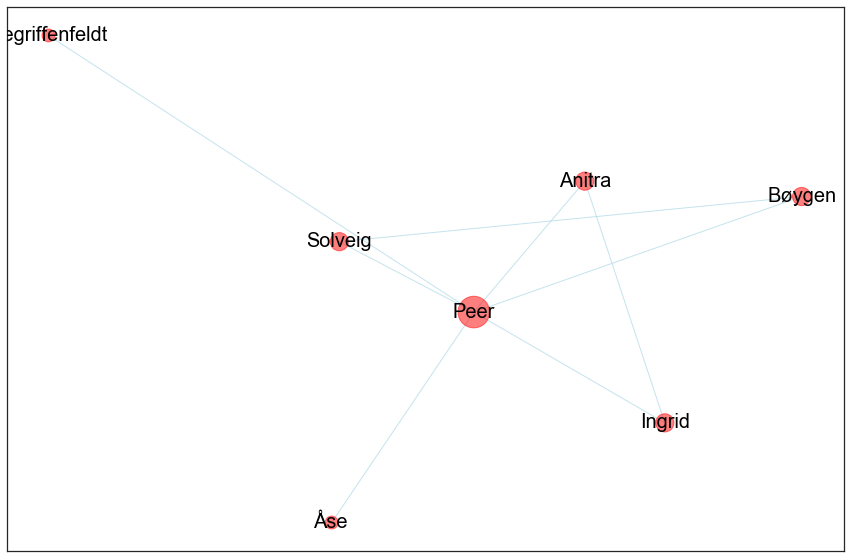

In [49]:
draw_graph_centrality(Gp2)

True

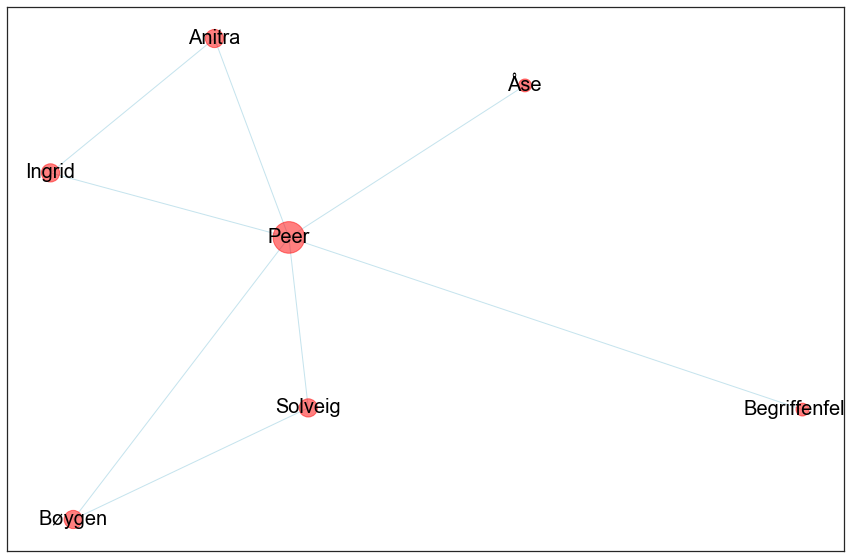

In [5]:
draw_graph_centrality(Gp2)

True

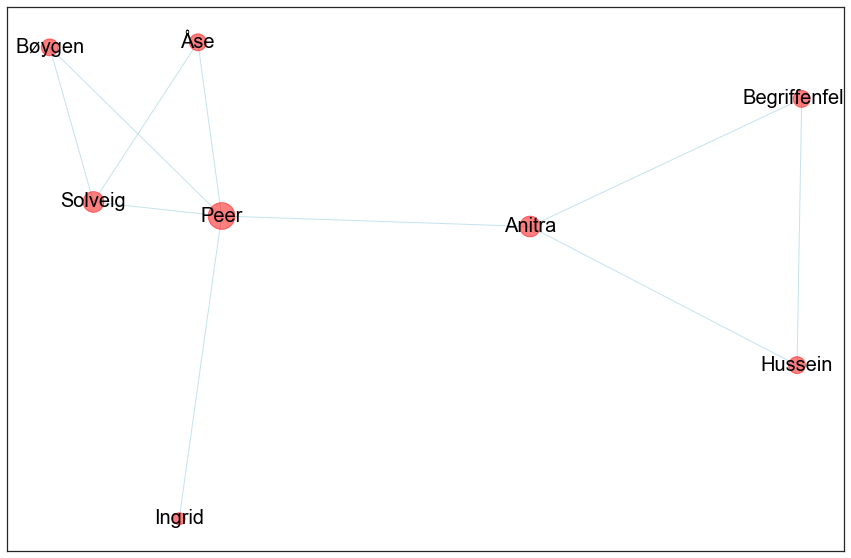

In [90]:
draw_graph_centrality(Gm)

True

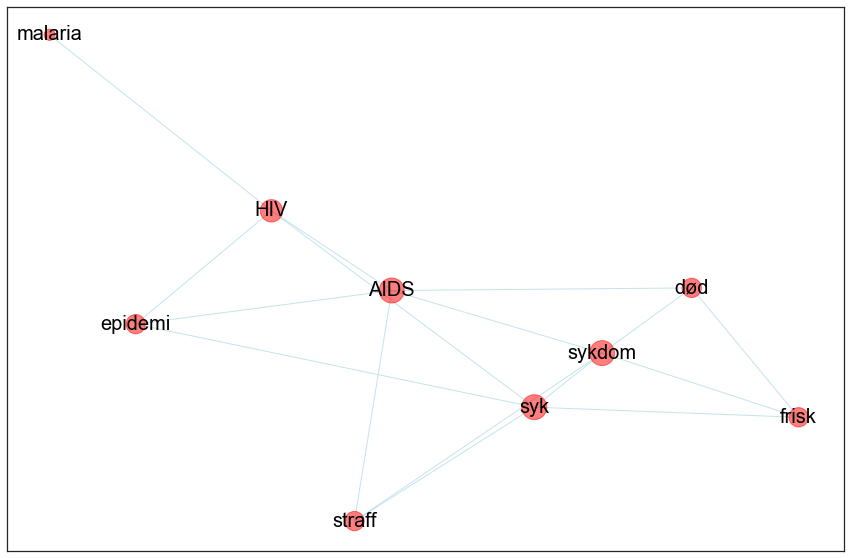

In [107]:
draw_graph_centrality(G)


<div style="font-family:'Palatino Linotype';font-size:1.2em">
Et eksempel med demokrat og noen av ordene fra forskjellige serieclusterene - her har jeg tatt topp 10 fra noen av dem.

In [114]:
G1 = make_newspaper_network('demokrati',"""vårt, frihet, et, diktatur, demokrati, økonomisk, levende, lever, 
menneskerettigheter, eit, fred, et, vårt, frihet, menneskerettigheter, 
diktatur, fred, markedsøkonomi, levende, folkestyre, vårt, frihet, et, økonomisk, 
diktatur, levende, økonomiske, fred, virkelig, demokrati, politiske, sant, politisk, form, moderne""".split(', '), yearfrom=1980, yearto=1990, limit=20)

True

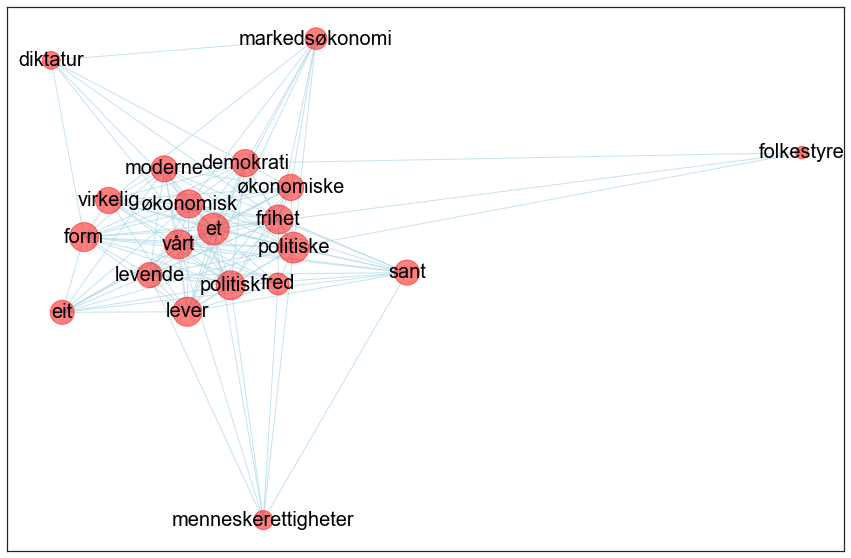

In [115]:
draw_graph_centrality(G1)

In [116]:
G2 = make_newspaper_network('demokrati',"""vårt, frihet, et, diktatur, demokrati, økonomisk, levende, lever, 
menneskerettigheter, eit, fred, et, vårt, frihet, menneskerettigheter, 
diktatur, fred, markedsøkonomi, levende, folkestyre, vårt, frihet, et, økonomisk, 
diktatur, levende, økonomiske, fred, virkelig, demokrati, politiske, sant, politisk, form, moderne""".split(', '), yearfrom=1950, yearto=1970, limit=20)

True

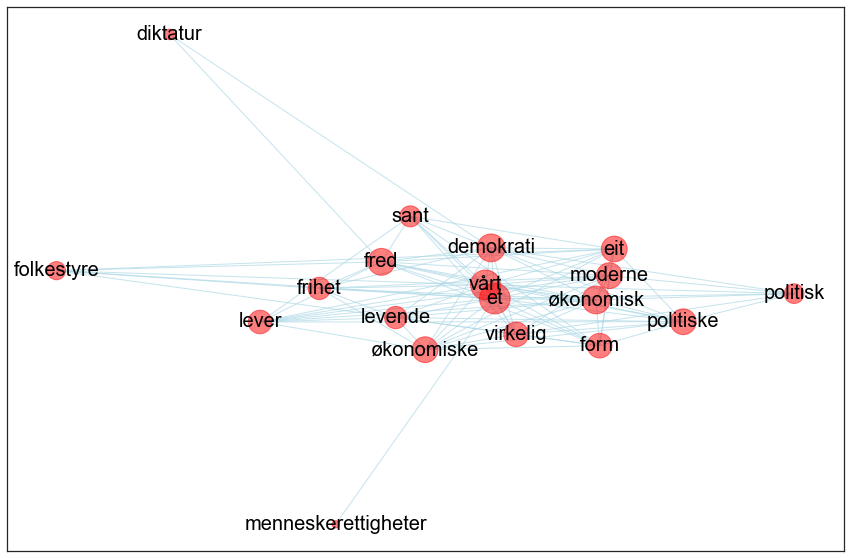

In [117]:
draw_graph_centrality(G2)